# Matbench Perovskite Dataset

Exploratory Data Analysis (EDA). [MPContribs link](https://ml.materialsproject.org/projects/matbench_perovskites)


In [ ]:
# matminer needed for loading data
!pip install pymatviz matminer

In [ ]:
import pandas as pd
import plotly.express as px
import plotly.io as pio

# see https://github.com/CompRhys/aviary/blob/main/aviary/wren/utils.py
from aviary.wren.utils import get_aflow_label_from_spglib
from matminer.datasets import load_dataset
from tqdm import tqdm

from pymatviz import plot_structure_2d, ptable_heatmap_plotly, spacegroup_sunburst
from pymatviz.enums import Key
from pymatviz.io import save_and_compress_svg
from pymatviz.powerups import annotate_bars
from pymatviz.sankey import sankey_from_2_df_cols
from pymatviz.utils import crystal_sys_from_spg_num


__author__ = "Janosh Riebesell"
__date__ = "2022-03-19"


# Interactive plotly figures don't show up on GitHub.
# https://github.com/plotly/plotly.py/issues/931
# change renderer from "svg" to "notebook" to get hover tooltips back
# (but blank plots on GitHub!)
pio.renderers.default = "png"

In [ ]:
df_perov = load_dataset("matbench_perovskites")

df_perov[[Key.spg_symbol, Key.spg_num]] = [
    struct.get_space_group_info() for struct in tqdm(df_perov[Key.structure])
]
df_perov[Key.volume] = df_perov[Key.structure].map(lambda struct: struct.volume)

df_perov[Key.formula] = df_perov[Key.structure].map(lambda cryst: cryst.formula)

df_perov[Key.crystal_system] = df_perov[Key.spg_num].map(crystal_sys_from_spg_num)

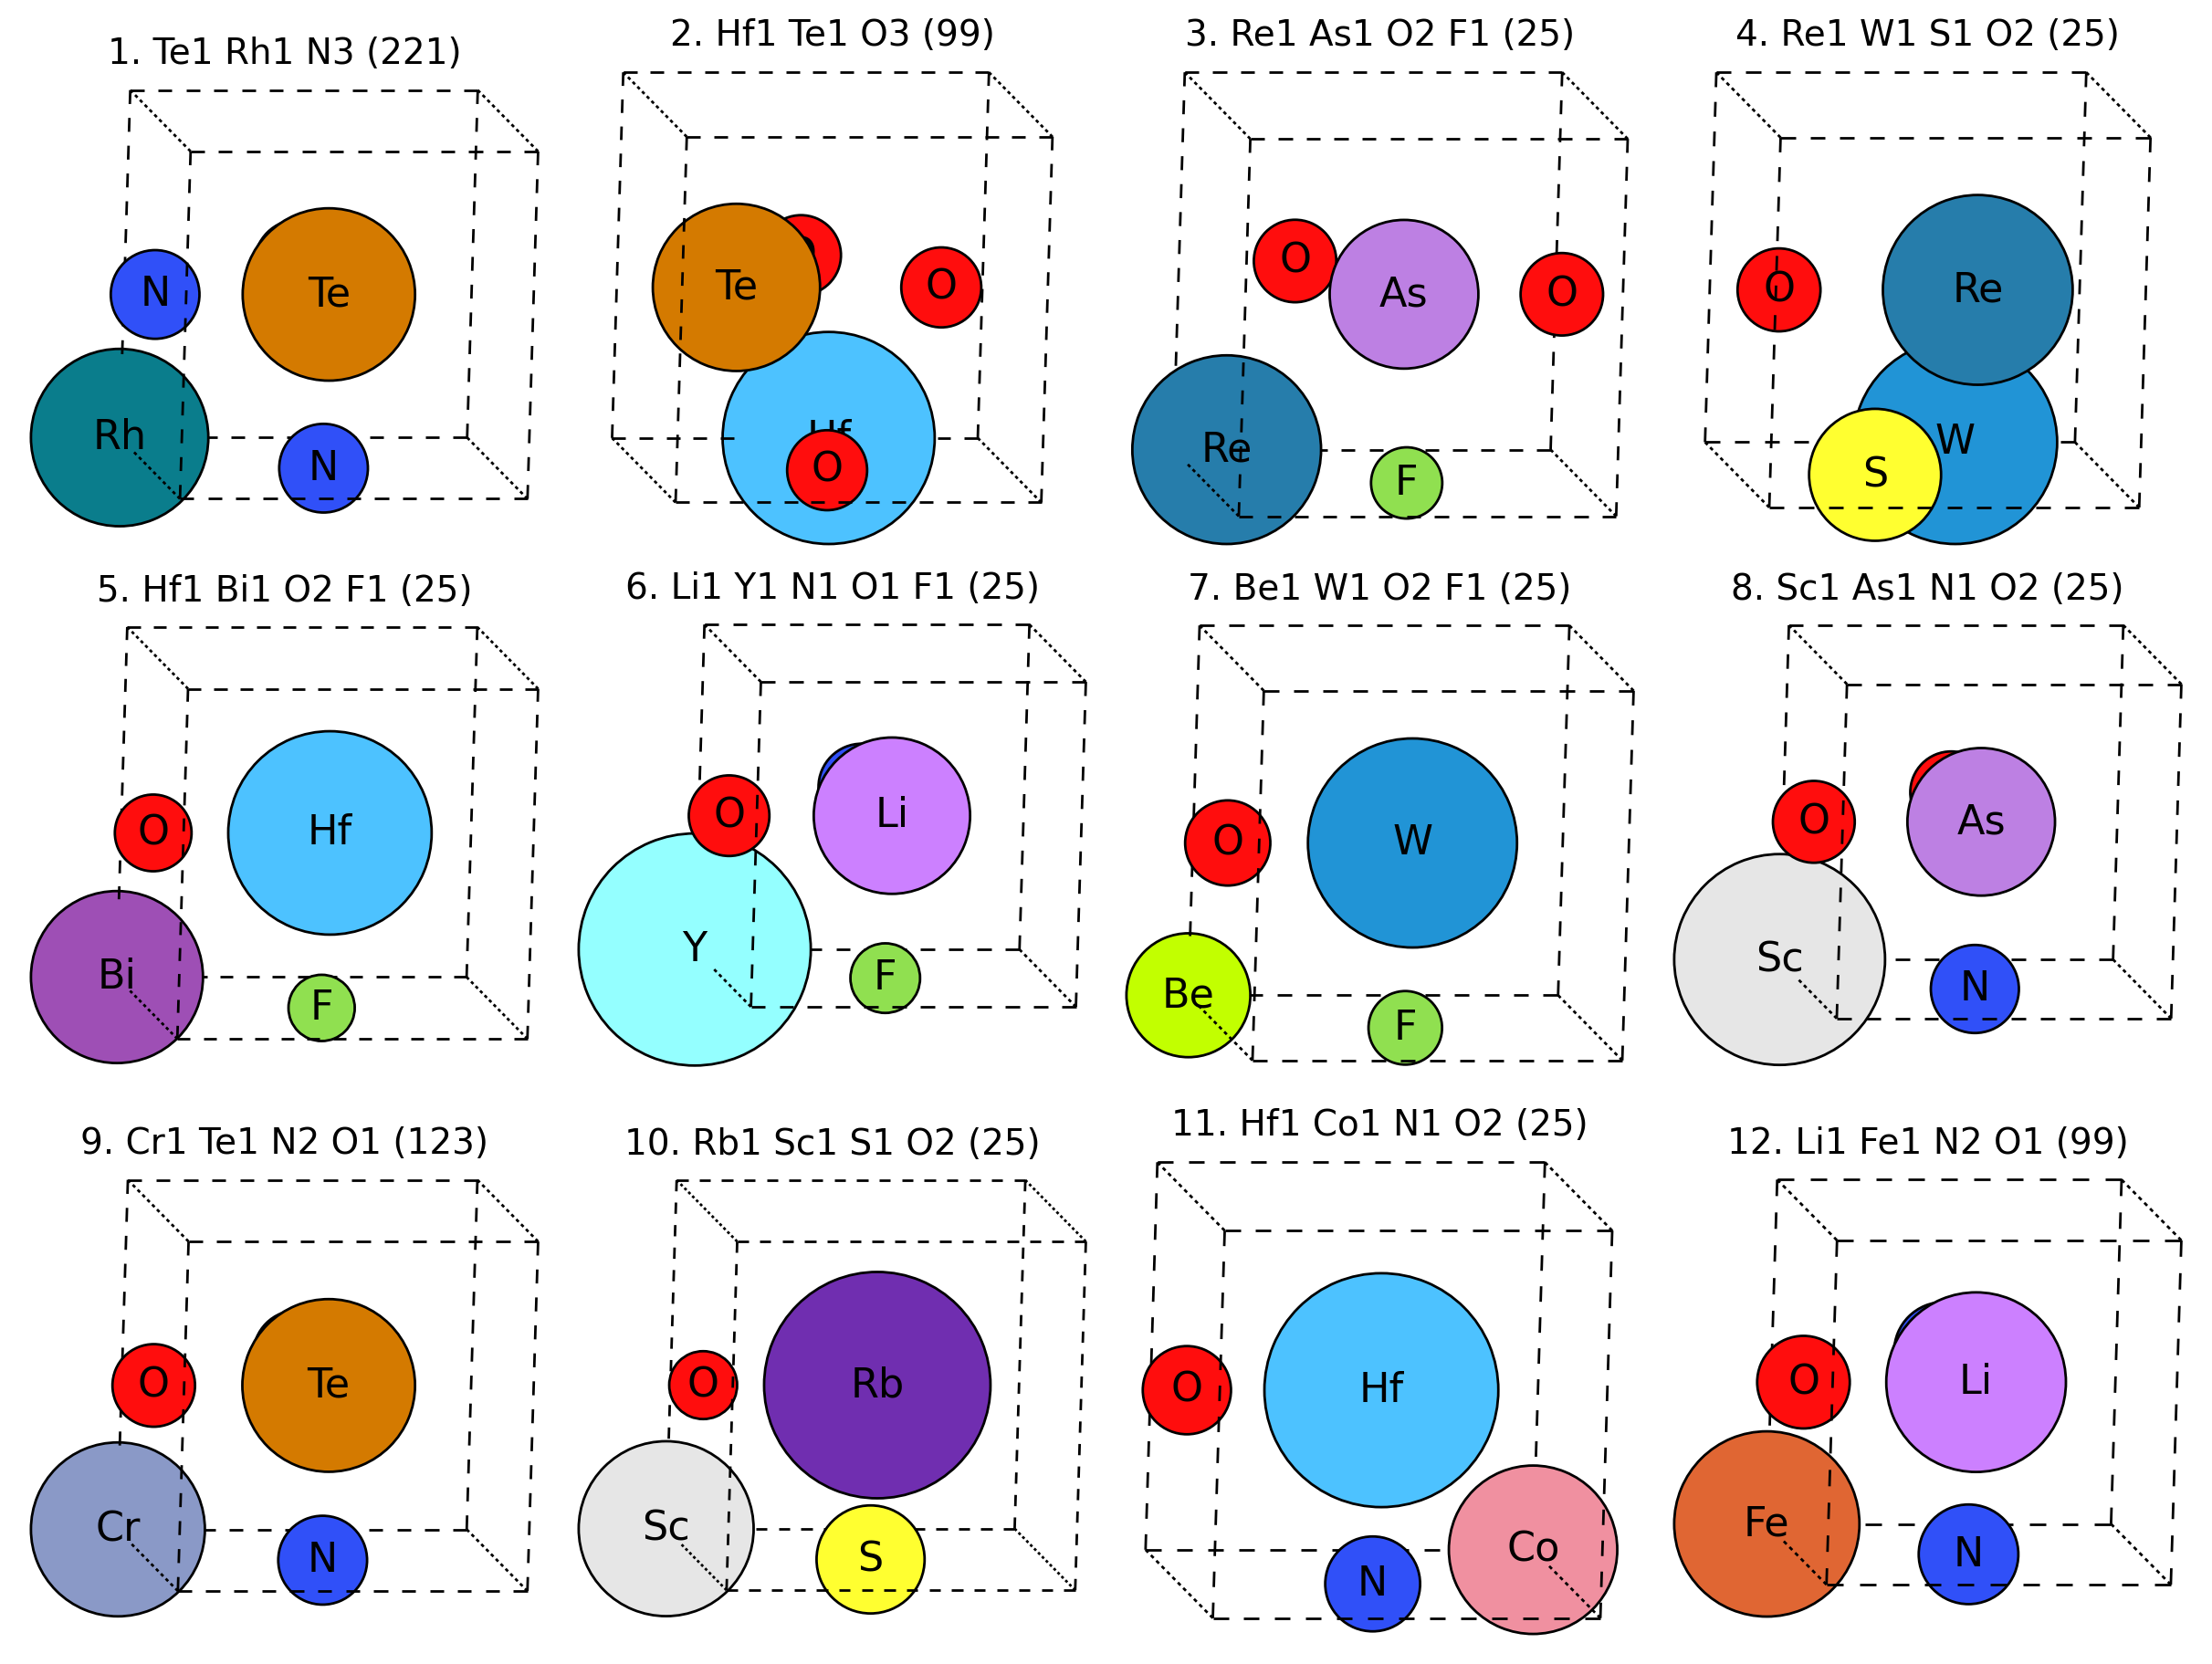

In [ ]:
fig, axs = plot_structure_2d(df_perov[Key.structure].iloc[:12])

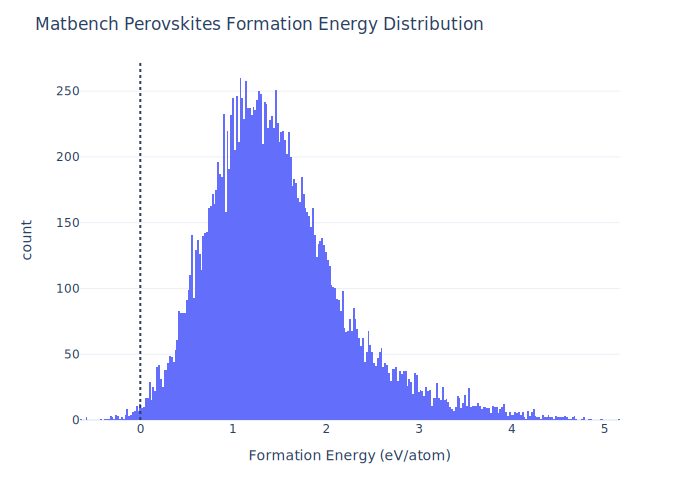

In [ ]:
labels = {"e_form": "Formation Energy (eV/atom)"}

fig = px.histogram(df_perov, x="e_form", nbins=300, labels=labels)

fig.layout.title = "Matbench Perovskites Formation Energy Distribution"

fig.add_vline(x=0, fillcolor="black", line=dict(width=2, dash="dot"))

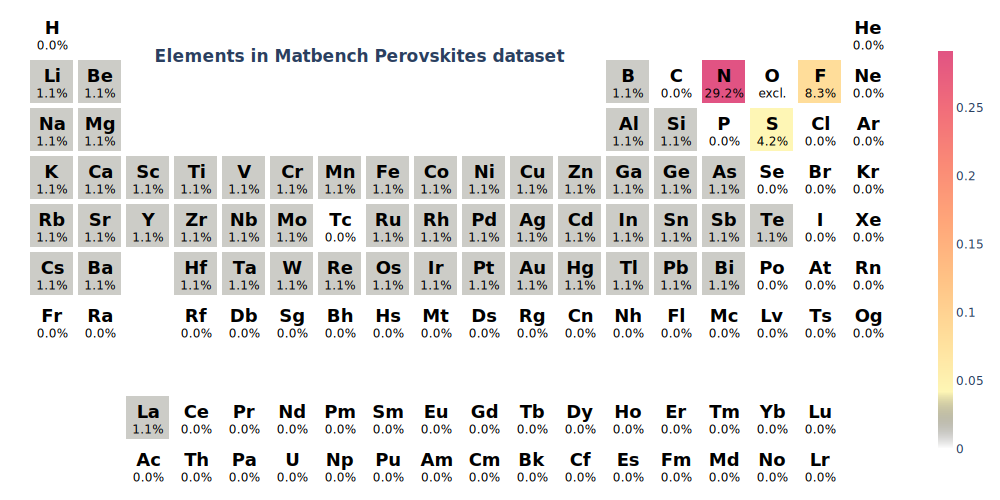

In [ ]:
fig = ptable_heatmap_plotly(
    df_perov[Key.formula], exclude_elements=["O"], heat_mode="percent"
)
fig.update_layout(
    title=dict(text="<b>Elements in Matbench Perovskites dataset</b>", x=0.36, y=0.9)
)

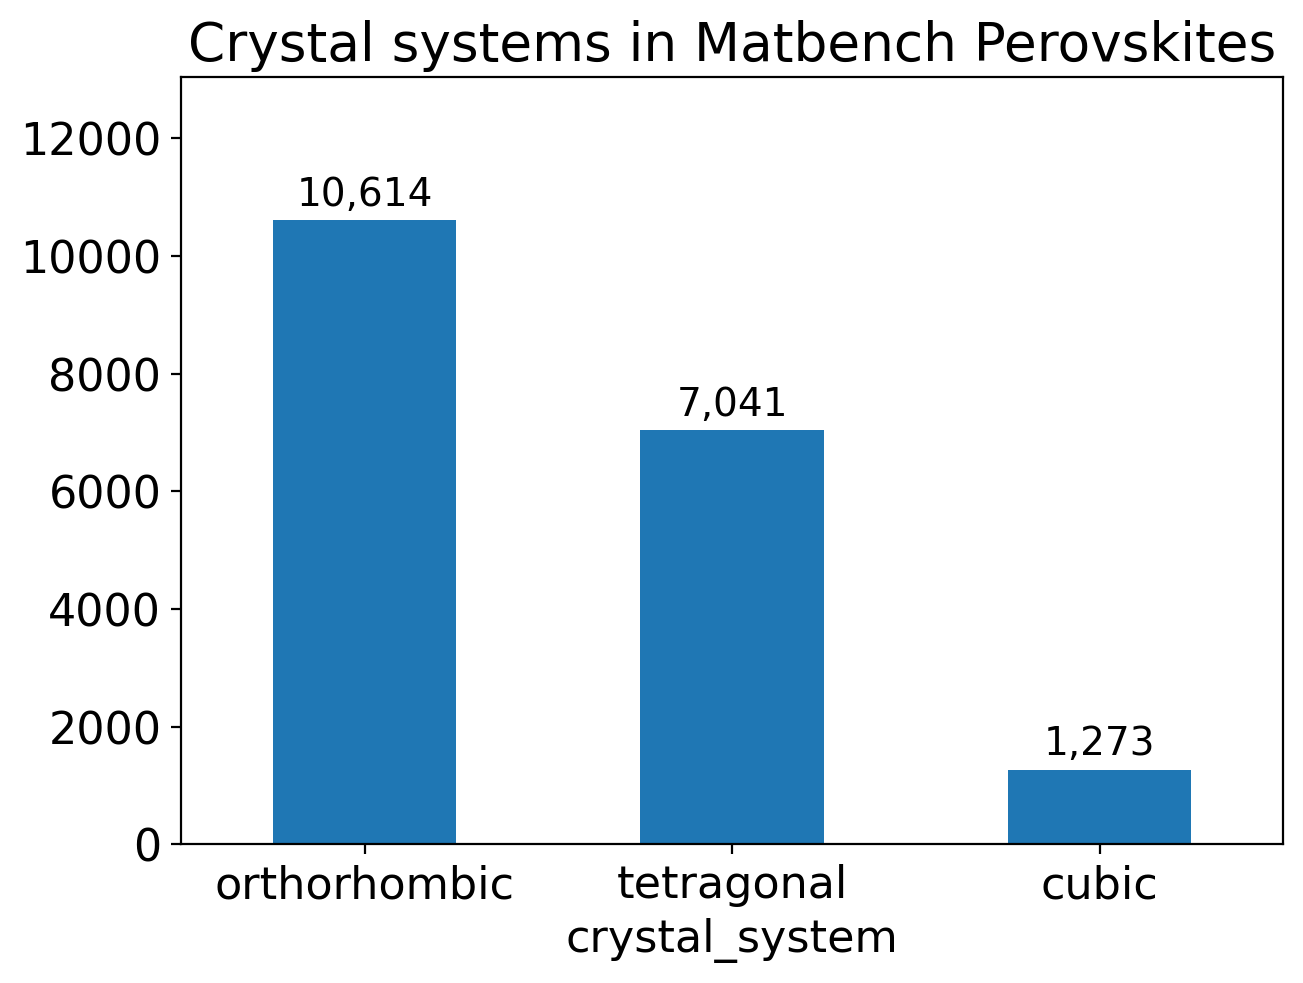

In [ ]:
ax = df_perov[Key.crystal_system].value_counts().plot.bar(rot="horizontal")

ax.set(title="Crystal systems in Matbench Perovskites")

annotate_bars(ax, v_offset=250)

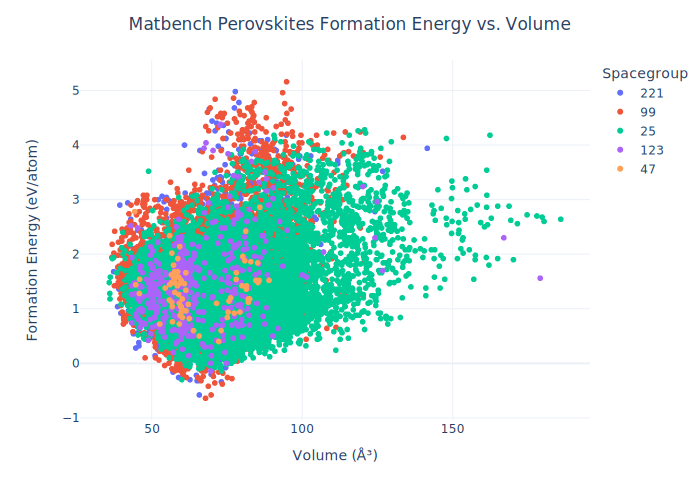

In [ ]:
labels = {
    "spglib_spg_num": "Spacegroup",
    "e_form": "Formation Energy",
    "volume": "Volume",
}

fig = px.scatter(
    df_perov, x="volume", y="e_form", color="spglib_spg_num", labels=labels
)
fig.layout.title = dict(text="Matbench Perovskites Formation Energy vs. Volume", x=0.5)

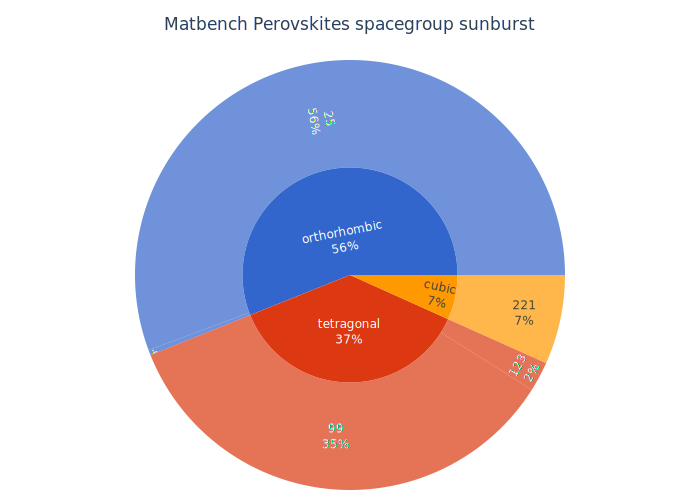

In [ ]:
fig = spacegroup_sunburst(df_perov.spglib_spg_num, show_counts="percent")
fig.layout.title = dict(text="Matbench Perovskites spacegroup sunburst", x=0.5)

In [ ]:
# takes ~6h (when running uninterrupted)
for idx, struct in tqdm(df_perov[Key.structure].items(), total=len(df_perov)):
    if pd.isna(df_perov.aflow_wyckoff[idx]):
        df_perov.loc[idx, "aflow_wyckoff"] = get_aflow_label_from_spglib(
            struct,
            "/path/to/aflow",  # defaults to aflow
        )

In [ ]:
df_perov["aflow_wyckoff"] = pd.read_csv(
    # 2022-05-17-matbench_perovskites_aflow_labels.csv
    "https://docs.google.com/spreadsheets/d/"
    "1Mhk5t3Ac_aHOTWMjZ1DL4LtUBIB21nWt7oy2t3M-fQU/export?format=csv"
).aflow_wyckoff

In [ ]:
# uncomment line to cache expensive aflow results
# %store df_perov

# uncomment line to reload cached dataframe
%store -r df_perov

extract spacegroups and crystal systems from Aflow Wyckoff labels


In [ ]:
df_perov["aflow_spg_num"] = df_perov.aflow_wyckoff.str.split("_").str[2].astype(int)
df_perov["aflow_crys_sys"] = df_perov.aflow_spg_num.map(crystal_sys_from_spg_num)

Surprisingly large disparity between Spglib and Aflow spacegroups

Spglib is fast while Aflow uses a slower adaptive but presumably more correct algorithm.



sankey-spglib-vs-aflow-spacegroups.svg:
Done in 79 ms!
10.74 KiB - 37.1% = 6.752 KiB


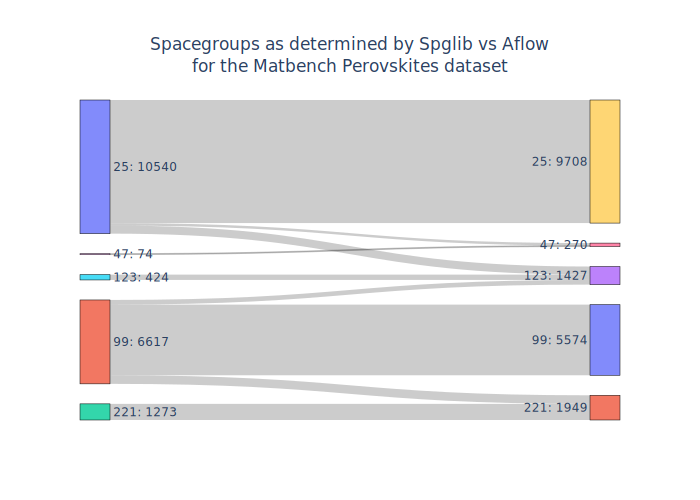

In [ ]:
fig = sankey_from_2_df_cols(df_perov, ["spglib_spg_num", "aflow_spg_num"])

title = "Spglib vs Aflow Spacegroups<br>for the Matbench Perovskites dataset"

fig.layout.title = dict(text=title, x=0.5)

save_and_compress_svg(fig, "sankey-spglib-vs-aflow-spacegroups")

fig.show()

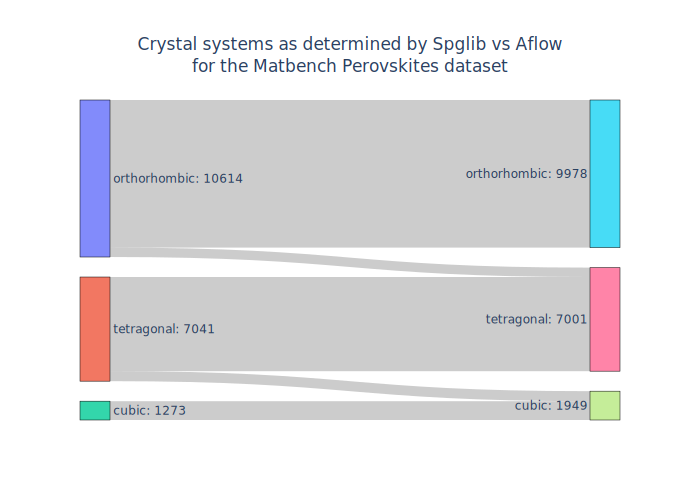

In [ ]:
fig = sankey_from_2_df_cols(df_perov, ["spglib_crys_sys", "aflow_crys_sys"])

title = "Spglib vs Aflow Crystal systems<br>for the Matbench Perovskites dataset"
fig.layout.title = dict(text=title, x=0.5)